# Lab Assignment Two: Exploring Image Data
Name: Marc Pham, Alonso Gurrola

## 1. Business Understanding

The RealWaste dataset comprises 4,752 color images of waste material at the Whyte’s Gully Waste and Resource Recovery facility in Wollongong NSW Australia.  Each image has a resolution of 524x524 and is classified as 1 of 9 possible categories of waste: cardboard, food organics, glass, metal, miscellaneous trash, paper, plastic, textile trash, and vegetation.  For a breakdown of the number of images per category, refer to *Section 2.2:  Creating the Labels*.  The data was originally collected for an honors thesis investigating the performance of convolutional neural networks in classifying authentic waste material.  Specifically, the researchers wanted to compare how the CNN would perform when trained on waste in its pure form rather than real waste items.

Our goal is to use this dataset to predict the category of waste that each image falls into.  The prediction algorithm would help environmental agencies, such as the United States’ Environmental Protection Agency (EPA), to automate waste segregation, which is the process of organizing waste into different categories based on their characteristics.  Effective waste segregation is crucial for these agencies to ensure proper recycling and the safe disposal of hazardous materials. As of 2022, waste segregation remains a global challenge, with over 33% of the world’s 2.01 billion tons of solid waste not being properly segregated.  For our prediction algorithm to be effective, the algorithm must minimize the percentage of misclassified waste.  Currently, the highest accuracy achieved by similar algorithms (which classify waste into more than 2 categories) is 77%.  Therefore, our algorithm should achieve an accuracy above 80%, so no more than 20% of the waste is misclassified.

Dataset: [Data](https://archive.ics.uci.edu/dataset/908/realwaste)

Original Paper: [RealWaste: A Novel Real-Life Data Set for Landfill Waste Classification Using Deep Learning](https://www.mdpi.com/2078-2489/14/12/633)

Waste Segregation Statistics: [The Importance of Waste Segregation](https://axil-is.com/blogs-articles/waste-segregation/#:~:text=Environmental%20Problems&text=However%2C%20at%20least%2033%25%20of,no%20longer%20afford%20to%20ignore)

Accuracy of Previous Algorithms: [Previous Algorithms](https://www.sciencedirect.com/science/article/pii/S2212095523000792#:~:text=ML%20is%20used%20for%20efficient,waste%20prediction%20and%20classification%20accuracy)

## 2. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
from PIL import Image
from skimage import color
import cv2
import time

from skimage.feature import daisy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# import warnings
# warnings.filterwarnings('ignore')

### 2.1: Loading the Images

In [2]:
data_path = "RealWaste_data/"
os.chdir(data_path)

To prepare the data, we read in the images as numpy arrays. The images are already the same size (524x524) and was represented as color images.  To pre-process these images, we turn the images into grayscale and downsized the image to be 25% of its original size, so the images are now be 131x131.  We did this so doing PCA and DAISY feature extraction would not take too long, and we would not lose important information on the general shape and size of the object.  We then linearized the images to create a table of 1-D image features.

Category Cardboard is complete!
Category Food Organics is complete!
Category Glass is complete!
Category Metal is complete!
Category Miscellaneous Trash is complete!
Category Paper is complete!
Category Plastic is complete!
Category Textile Trash is complete!
Category Vegetation is complete!
Time: 22.1687 seconds


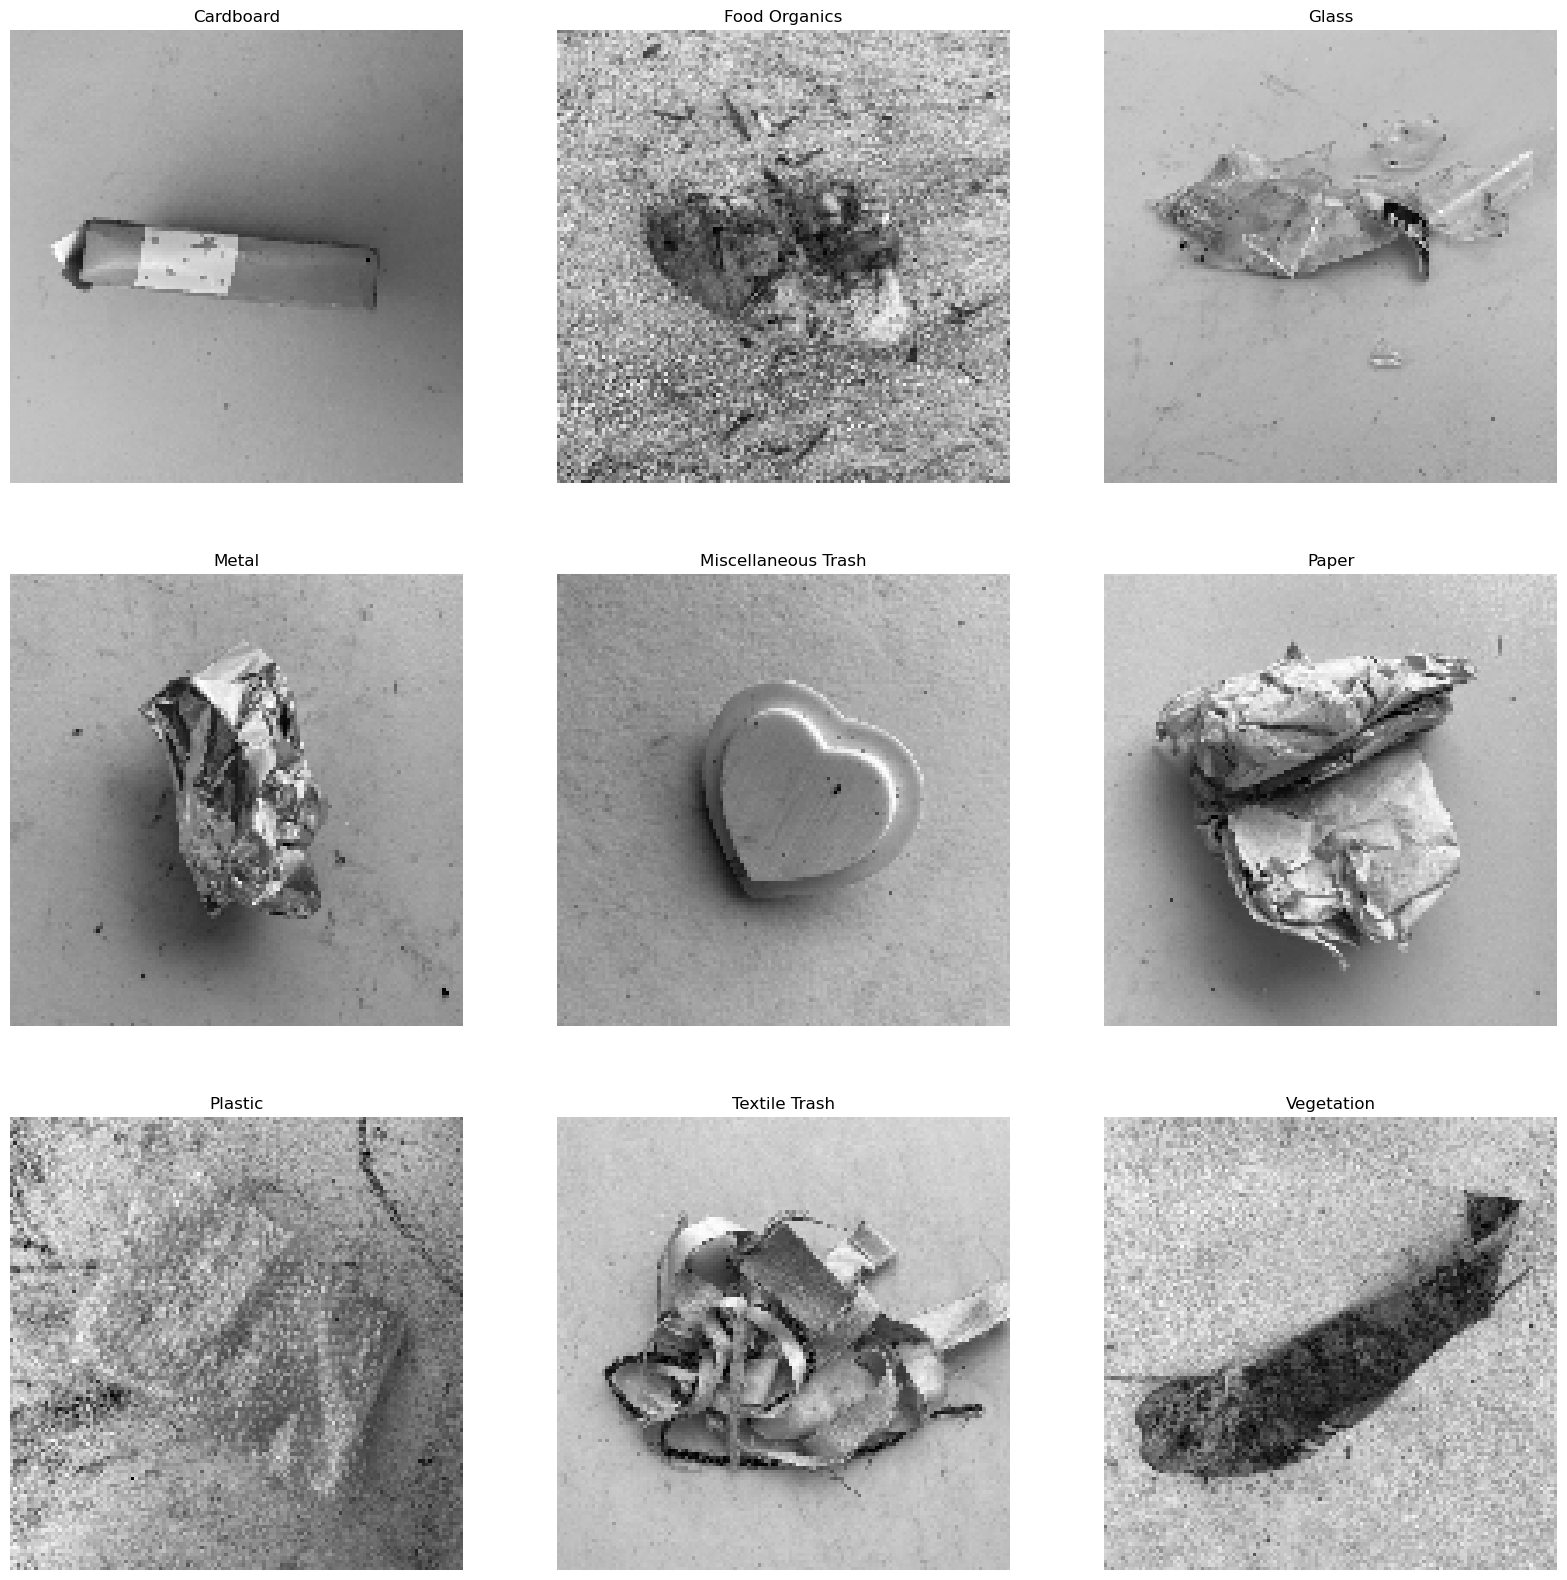

In [3]:
start = time.time()

num_jpgs = []
data_set = []

fig = plt.figure(figsize=(20,20))
count = 1

# Remove any hidden files
categories = sorted(os.listdir())
for i in range(len(categories) - 1, -1, -1):
    if categories[i][0] == '.':
        categories.pop(i)

for category in categories:
    
    os.chdir(category)
    num_jpgs.append(len(os.listdir()))

    printt = True
    
    for img_name in os.listdir():

        # Read in the images as numpy arrays, then linearize them.
        img = color.rgb2gray(Image.open(img_name))
        img = cv2.resize(img, None, fx=0.25, fy=0.25)
        
        data_set.append(img.ravel())

        # Output 1 Image from each of the Categories.
        if printt:
            ax = fig.add_subplot(3, 3, count)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(category)
            count += 1
            printt = False

    os.chdir("../")
    print(f"Category {category} is complete!")

end = time.time()
print(f"Time: {(end-start):.4f} seconds")

### 2.2: Creating the Labels

In [4]:
labels = np.repeat([i for i in range(1,10)], num_jpgs)
Labels = pd.DataFrame()
Labels['Labels'] = categories
Labels['Number of Label'] = [i for i in range(1,10)]
Labels['Number of Occurrences'] = num_jpgs
print(f"Total Number of Occurrences: {len(labels)}")
Labels

Total Number of Occurrences: 4752


,Labels,Number of Label,Number of Occurrences
0,Cardboard,1,461
1,Food Organics,2,411
2,Glass,3,420
3,Metal,4,790
4,Miscellaneous Trash,5,495
5,Paper,6,500
6,Plastic,7,921
7,Textile Trash,8,318
8,Vegetation,9,436


## 3. Data Reduction

### 3.1: PCA

Original shape: (4752, 17161)
Transformed shape: (4752, 1758)
Explained variance ratio: [1.52167652e-01 8.40069618e-02 8.13474135e-02 ... 4.19133243e-05
 4.18931417e-05 4.18566201e-05]


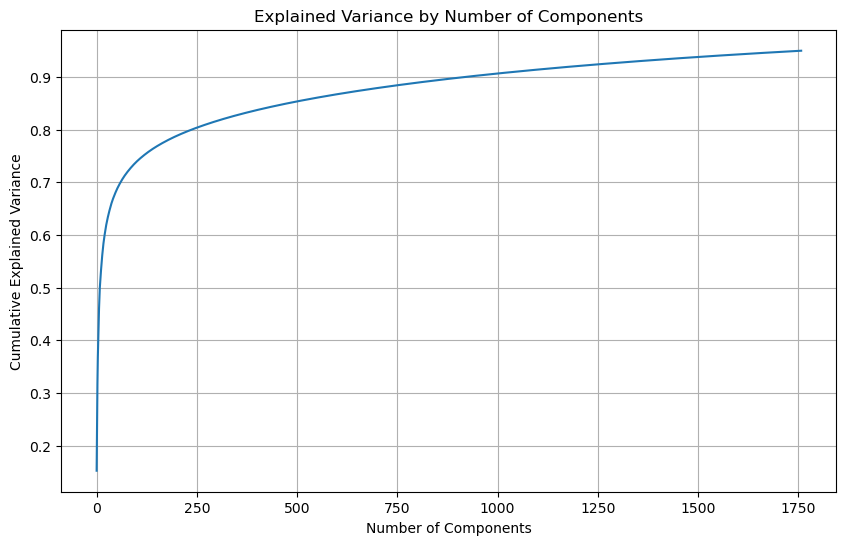

Time: 72.6056 seconds


In [32]:
from sklearn.decomposition import PCA

start = time.time()
# Convert the list to a numpy array
data_set = np.array(data_set)

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
n_pca_result = pca.fit_transform(data_set)

# Print the explained variance
print(f"Original shape: {data_set.shape}")
print(f"Transformed shape: {n_pca_result.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid()
plt.show()

end = time.time()
print(f"Time: {(end-start):.4f} seconds")

We decided to use 1224 components (dimensions) to adequately represent the image data. Although the cumulative explained variance begins to stabilize around 250 dimensions, the explained variance was only around 80%. To ensure we retained enough data variance, we set a target of 90% explained variance, which required at least 1000 dimensions. Additionally, to fairly compare the performance of PCA with feature extraction techniques like DAISY, we wanted to use the same number of dimensions for each technique. Since DAISY feature extraction has 1224 dimensions per example (reference *Section 3.4: DAISY Feature Extraction*), we wanted to use the same number of components for PCA.

To compare the performance of PCA with other techniques, we decided to build a nearest neighbor classifier to measure actual classification performance.

In [11]:
accuracies = []

for n in range(1, 10):  # k = 1 to 9
    for seed in range(0, 10):  # random_state = 0 to 9
        knn = KNeighborsClassifier(n_neighbors=n)  # KNN Classifier
        
        # Split the PCA-transformed data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            n_pca_result[:,0:1224], labels, test_size=0.2, train_size=0.8, random_state=seed
        )
        
        # Train and evaluate the KNN classifier
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # Append accuracy to the list
        accuracies.append(acc)


,count,mean,std,min,25%,50%,75%,max
0,90.0,0.376387,0.016728,0.336488,0.366982,0.378023,0.388801,0.414301


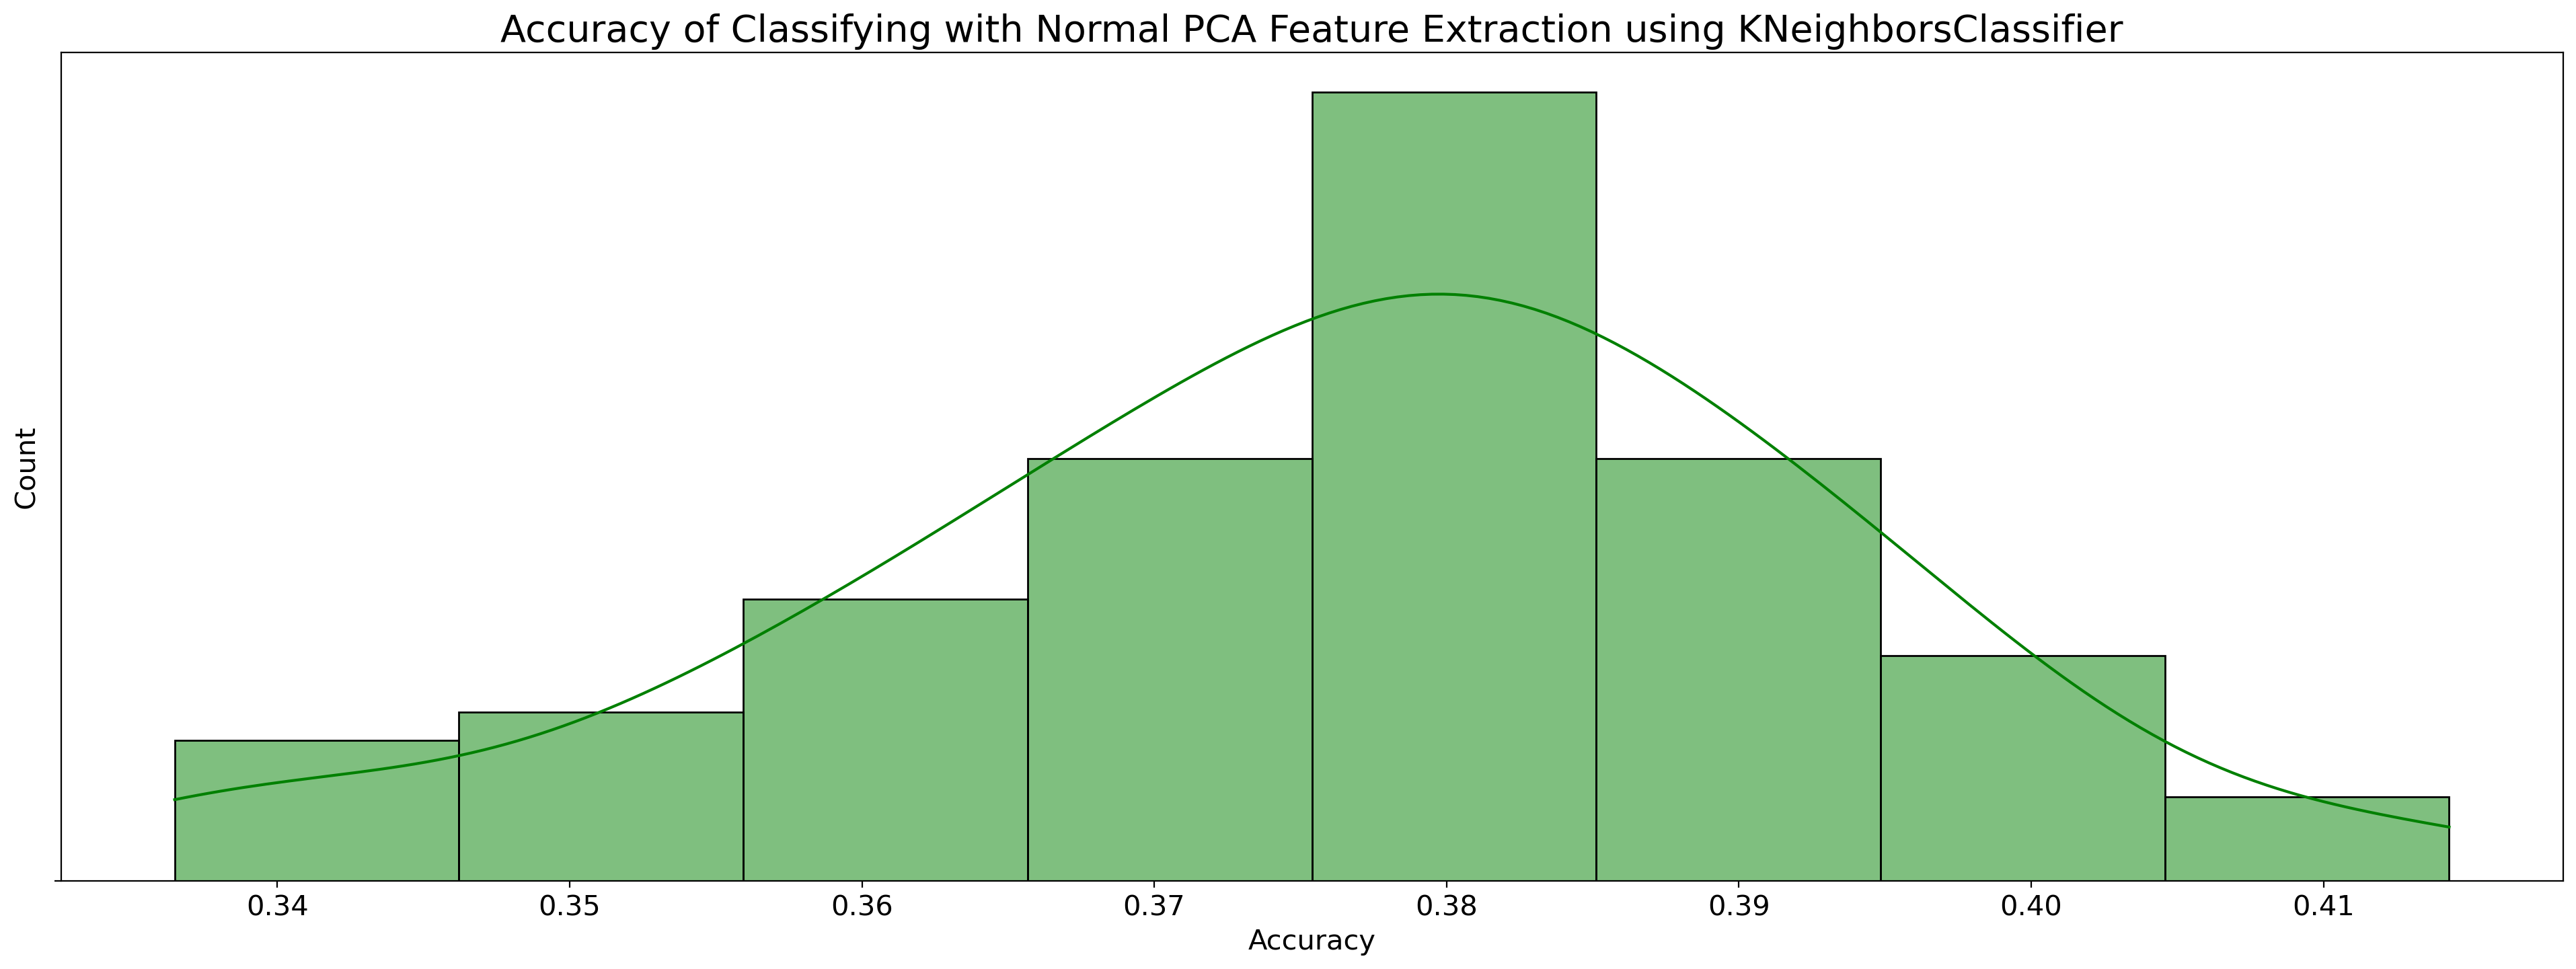

In [13]:
fig, axes = plt.subplots(1,1, figsize=(24,8), dpi=200)
sns.histplot(data=np.array(accuracies), color='green', kde=True)
plt.xlabel("Accuracy", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.yticks([0],[''], fontsize=15)
plt.xticks(np.arange(0.33,0.42,0.01),fontsize=15)
plt.margins(x=0.05, y=0.05)
plt.title("Accuracy of Classifying with Normal PCA Feature Extraction using KNeighborsClassifier", fontsize=20);
pd.DataFrame(pd.Series(accuracies).describe()).transpose()

Our tests showed that the median and mean accuracy of using DAISY Feature Extraction was around 37.8%. The maximum recorded accuracy was 41.4%, and the minimum recorded accuracy was 33.6%.

### 3.2: Randomized PCA

Shape of data_set: (4752, 17161)
No NaN values found in the dataset.
Original shape: (4752, 17161)
Transformed shape: (4752, 1758)
Explained variance ratio: [1.52167652e-01 8.40069618e-02 8.13474135e-02 ... 3.64570424e-05
 3.64425078e-05 3.64142015e-05]


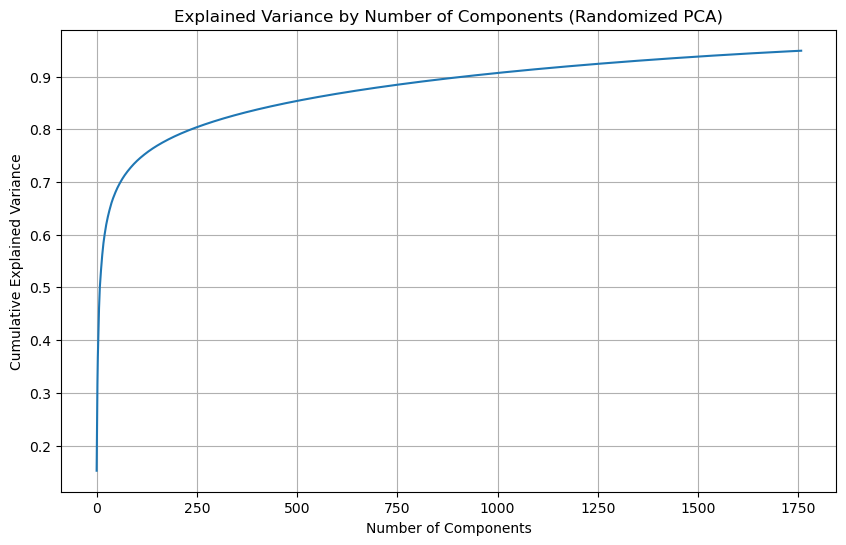

Time: 32.1005 seconds


In [20]:
start = time.time()
data_set = np.array(data_set)

# Check the shape of the data
print(f"Shape of data_set: {data_set.shape}")

# Ensure data_set is valid and numeric
if np.isnan(data_set).sum() > 0:
    print("There are NaN values in the dataset.")
else:
    print("No NaN values found in the dataset.")

# Perform Randomized PCA
randomized_pca = PCA(n_components= 1758, svd_solver='randomized', random_state=42)  # Randomized PCA
r_pca_result = randomized_pca.fit_transform(data_set)


# Print the explained variance
print(f"Original shape: {data_set.shape}")
print(f"Transformed shape: {r_pca_result.shape}")
print(f"Explained variance ratio: {randomized_pca.explained_variance_ratio_}")

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(randomized_pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components (Randomized PCA)')
plt.grid()
plt.show()

end = time.time()
print(f"Time: {(end-start):.4f} seconds")

Similar to normal PCA, we decided to use 1224 components (dimensions) to adequately represent the image data. If we aim for 90% explained variance like we did with normal PCA, we find that we will need at least 1000 dimensions. To fairly compare the performance of randomized PCA with normal PCA and feature extraction techniques like DAISY, we wanted to use the same number of dimensions for each technique, which was 1224 components.

In [15]:
accuracies = []

# Loop over different values of `k` and random seeds
for n in range(1, 10):  # k = 1 to 9
    for seed in range(0, 10):  # random_state = 0 to 9
        knn = KNeighborsClassifier(n_neighbors=n)
        
        # Split the PCA-transformed data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            r_pca_result[:,0:1224], labels, test_size=0.2, train_size=0.8, random_state=seed
        )
        
        # Train and evaluate the KNN classifier
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # Append accuracy to the list
        accuracies.append(acc)


,count,mean,std,min,25%,50%,75%,max
0,90.0,0.376387,0.016692,0.336488,0.365931,0.377497,0.38775,0.414301


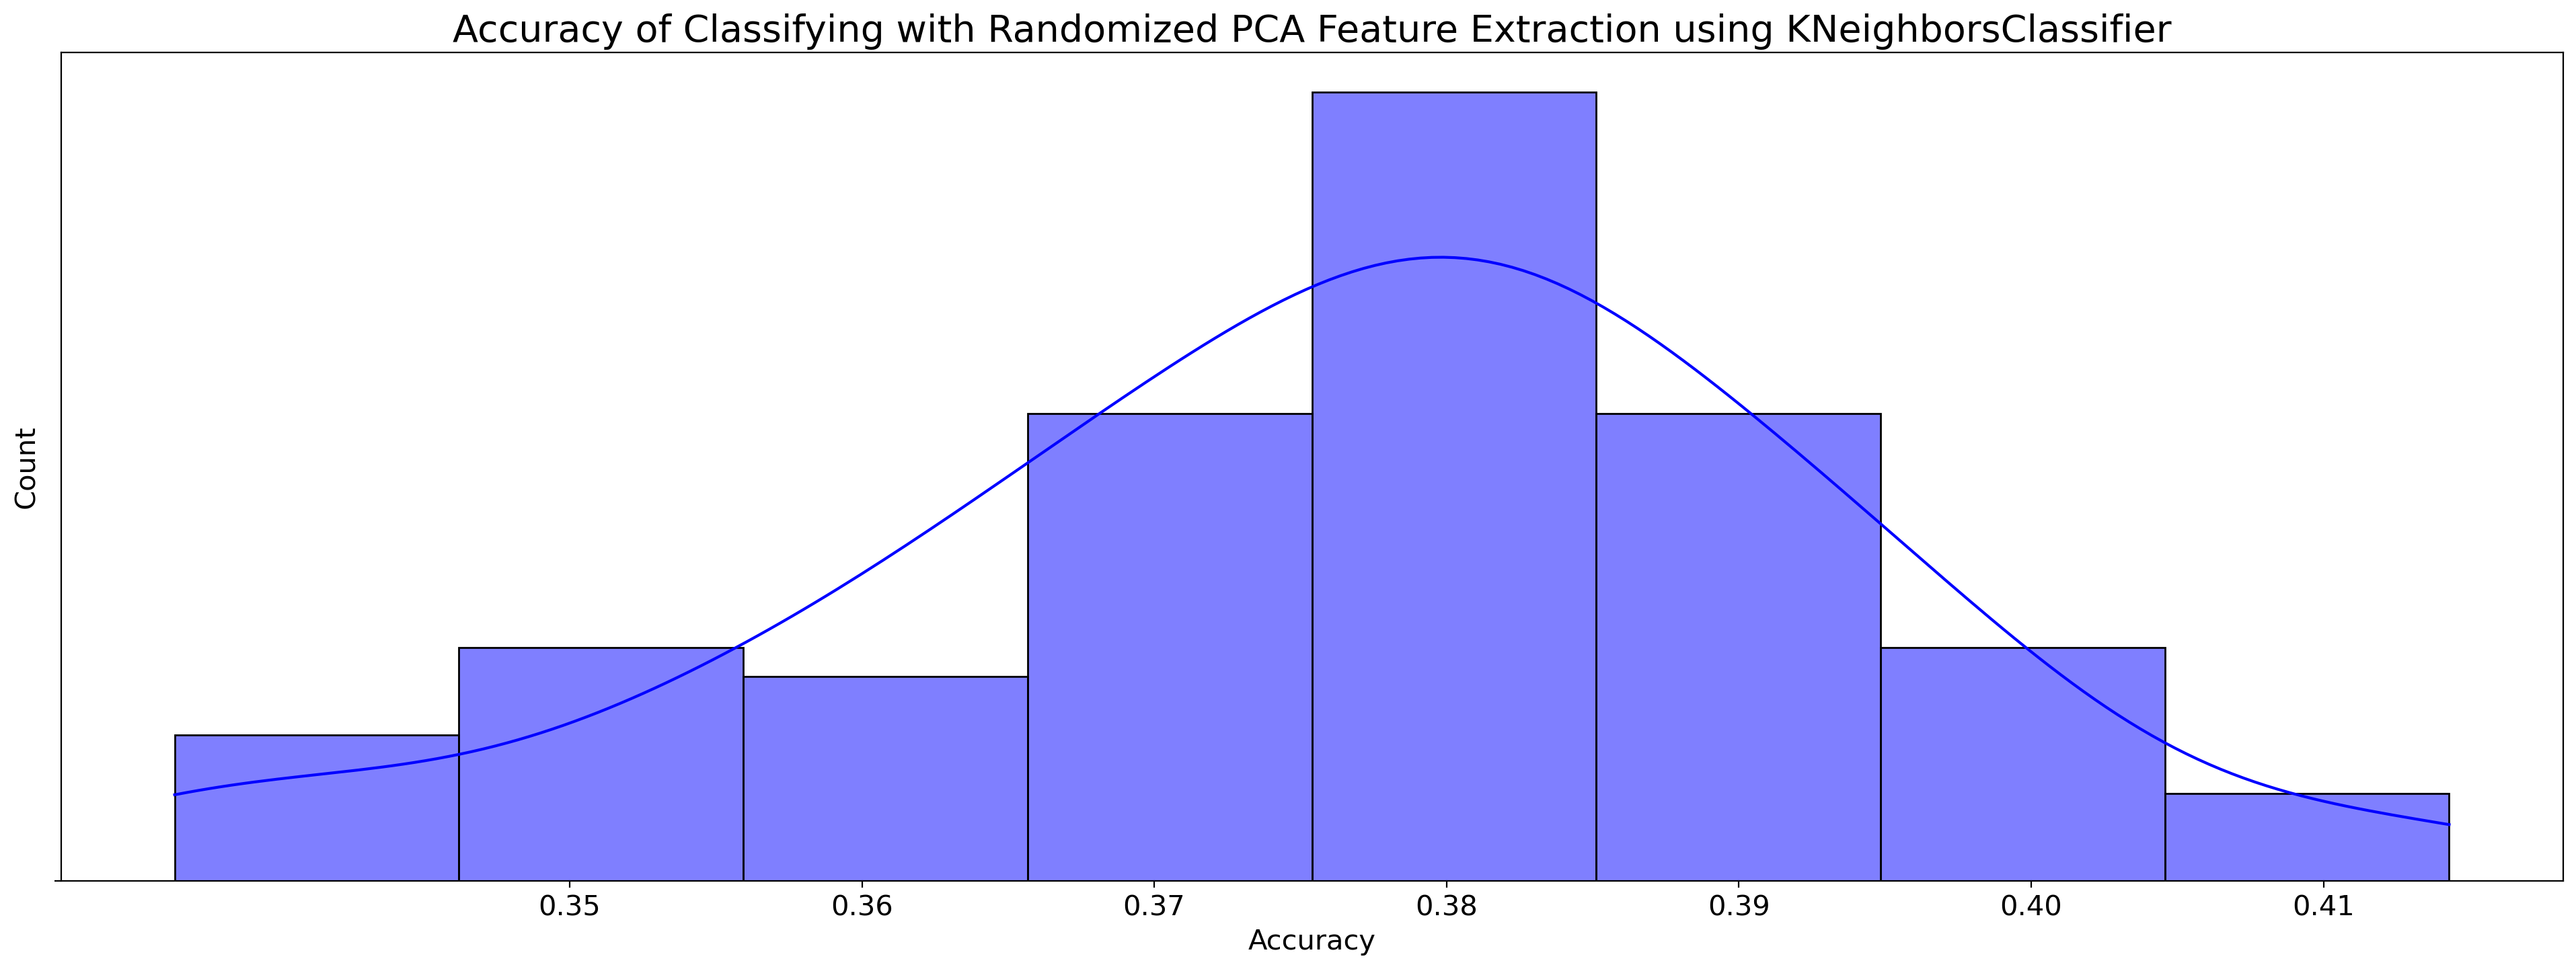

In [16]:
fig, axes = plt.subplots(1,1, figsize=(24,8), dpi=200)
sns.histplot(data=np.array(accuracies), color='blue', kde=True)
plt.xlabel("Accuracy", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.yticks([0],[''], fontsize=15)
plt.xticks(np.arange(0.35,0.49,0.01),fontsize=15)
plt.margins(x=0.05, y=0.05)
plt.title("Accuracy of Classifying with Randomized PCA Feature Extraction using KNeighborsClassifier", fontsize=20);
pd.DataFrame(pd.Series(accuracies).describe()).transpose()

When measuring performance with a nearest neighbors classifier, our tests showed that the median and mean accuracy of using DAISY Feature Extraction was around 37.7%. The maximum recorded accuracy was 41.4%, and the minimum recorded accuracy was 33.6%. These accuracy metrics are nearly identical to those of normal PCA, showing that there is little difference in prediction accuracy between normal PCA and randomized PCA.

### 3.3: Comparing PCA and Randomized PCA

To compare normal PCA and randomized PCA, we visualized the difference in Cumulative Explained Variance between the two techniques. In our plot, $\text{Difference in Cumulative Explained Variance} = \text{Cumulative Explained Variance}_{\text{Normal PCA}} - \text{Cumulative Explained Variance}_{\text{Randomized PCA}}$

Normal PCA - Original shape: (4752, 17161), Transformed shape: (4752, 1758)
Randomized PCA - Original shape: (4752, 17161), Transformed shape: (4752, 1758)


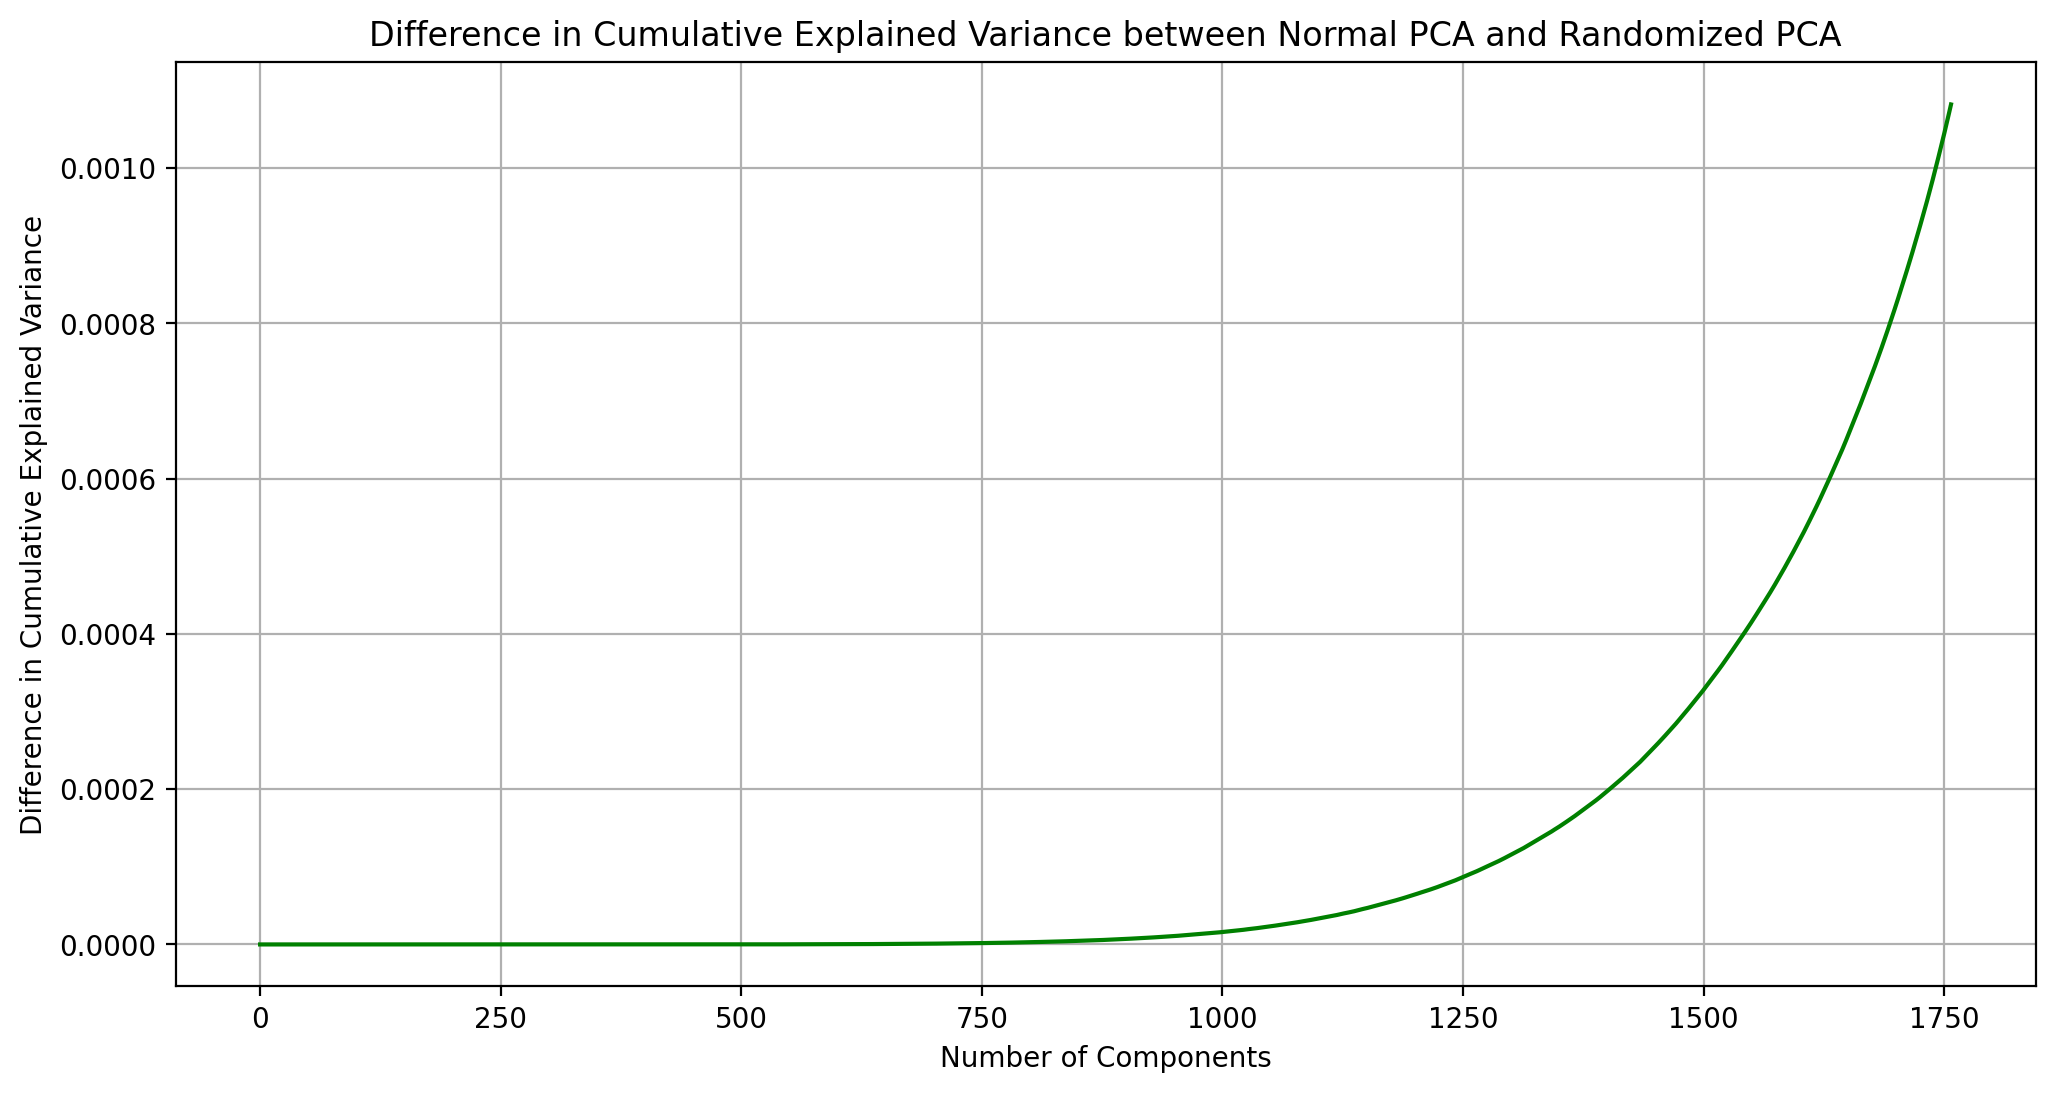

Reconstruction Error (Normal PCA): 0.0011
Reconstruction Error (Randomized PCA): 0.0011


In [30]:
import numpy as np
import matplotlib.pyplot as plt


# Print shapes
print(f"Normal PCA - Original shape: {data_set.shape}, Transformed shape: {n_pca_result.shape}")
print(f"Randomized PCA - Original shape: {data_set.shape}, Transformed shape: {r_pca_result.shape}")

# Cumulative explained variance
cumsum_pca = np.cumsum(pca.explained_variance_ratio_)
cumsum_randomized_pca = np.cumsum(randomized_pca.explained_variance_ratio_)

# Plotting
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(cumsum_pca - cumsum_randomized_pca, 'green')
# plt.plot(cumsum_pca, label='Normal PCA', color='green')
# plt.plot(cumsum_randomized_pca, label='Randomized PCA', color='blue')
plt.xlabel('Number of Components')
plt.ylabel('Difference in Cumulative Explained Variance')
plt.title('Difference in Cumulative Explained Variance between Normal PCA and Randomized PCA')
plt.grid()
plt.show()

# Reconstruction Error Function
def reconstruction_error(original, transformed, pca_model):
    reconstructed = pca_model.inverse_transform(transformed)
    error = np.mean((original - reconstructed) ** 2)
    return error

# Compute reconstruction error using existing PCA results
error_normal_pca = reconstruction_error(data_set, n_pca_result, pca)
error_randomized_pca = reconstruction_error(data_set, r_pca_result, randomized_pca)

print(f"Reconstruction Error (Normal PCA): {error_normal_pca:.4f}")
print(f"Reconstruction Error (Randomized PCA): {error_randomized_pca:.4f}")

Because the difference in cumulative explained variance is always positive or zero, normal PCA consistently achieves a higher or equal cumulative explained variance compared to randomized PCA. However, the highest difference is only around 0.001, indicating that normal PCA is at most 0.1% better than randomized PCA when using the same number of components. Given that normal PCA took 72.6 seconds (see *Section 3.1: PCA*) and randomized PCA took 32.1 seconds (see *Section 3.2: Randomized PCA*), the minimal improvement in cumulative explained variance does not justify the additional time required for normal PCA. Thus, we prefer randomized PCA due to its similar cumulative explained variance and significantly faster execution time compared to normal PCA.

### 3.4: DAISY Feature Extraction

We performed DAISY Feature Extraction on the Images with a step of 30 and a radius of 30 because these are the parameters needed to adequatedly cover each 131x131 image. Covering the Images any more did not lead to any improvements in classification accuracy.

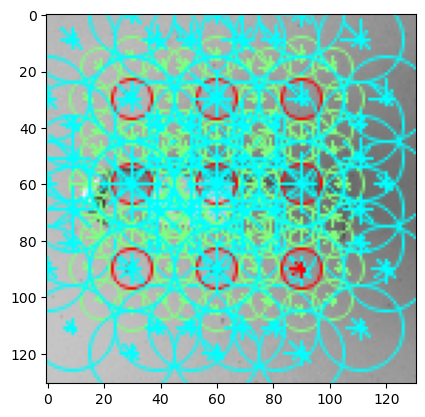

In [52]:
img_shape = [131,131]
features, img_desc = daisy(data_set[0].reshape(img_shape), 
                step=30, radius=30, rings=2, 
                histograms=8, orientations=8, visualize=True)
plt.imshow(img_desc)

In [54]:
def apply_daisy(row):
    img_shape = [131,131]
    features = daisy(row.reshape(img_shape), 
                    step=30, radius=30, rings=2, 
                    histograms=8, orientations=8, visualize=False)
    return features.ravel()

%time daisy_features = np.apply_along_axis(apply_daisy, 1, data_set)
print(daisy_features.shape)

CPU times: user 1min 43s, sys: 4.81 s, total: 1min 48s
Wall time: 1min 49s
(4752, 1224)


To determine whether or not DAISY feature extraction shows promise for our prediction task, we decided to build a nearest neighbor classifier to measure actual classification performance. Specifically, we tested how the nearest neighbor classifier would perform under different train-test splits (determined by the seed) and a different number of nearest neighbors used to classify each example.

In [86]:
accuracies = []

# init a classifier for each feature space
for n in range(1,10):
    for seed in range(0,10):
        knn_dsy = KNeighborsClassifier(n_neighbors=n)
        
        # separate the data into train/test
        dsy_train, dsy_test, y_train, y_test = train_test_split(
            daisy_features, labels, test_size=0.2, train_size=0.8, random_state=seed)
        
        knn_dsy.fit(dsy_train,y_train)
        acc_dsy = accuracy_score(knn_dsy.predict(dsy_test),y_test)
        accuracies.append(acc_dsy)


DAISY Accuracy: 47.32%


,count,mean,std,min,25%,50%,75%,max
0,950.0,0.420655,0.01706,0.356467,0.410095,0.42061,0.431125,0.473186


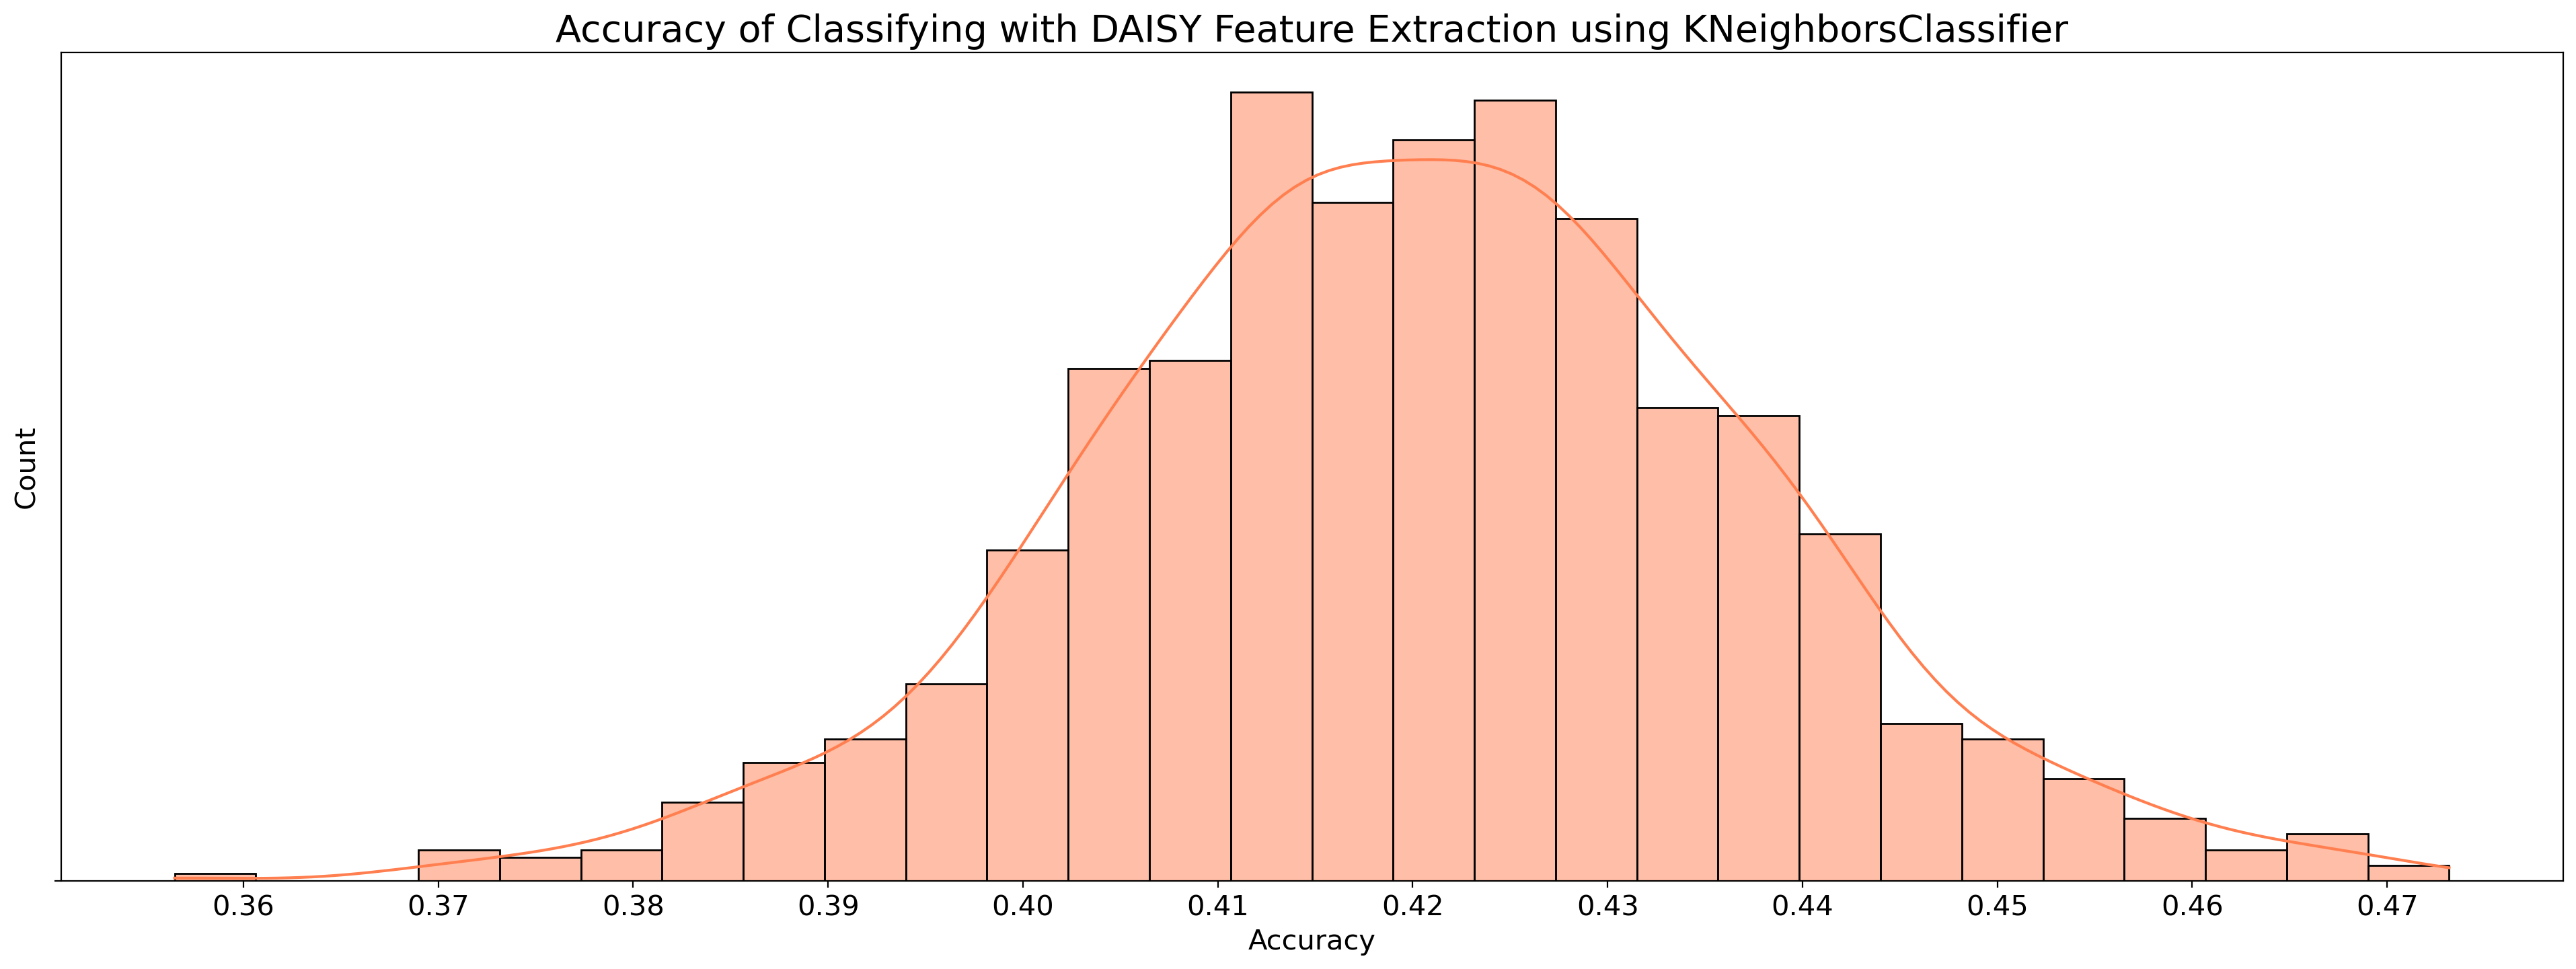

In [109]:
fig, axes = plt.subplots(1,1, figsize=(24,8), dpi=200)
sns.histplot(data=np.array(accuracies), color='coral', kde=True)
plt.xlabel("Accuracy", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.yticks([0],[''], fontsize=15)
plt.xticks(np.arange(0.35,0.49,0.01),fontsize=15)
plt.margins(x=0.05, y=0.05)
plt.title("Accuracy of Classifying with DAISY Feature Extraction using KNeighborsClassifier", fontsize=20);
pd.DataFrame(pd.Series(accuracies).describe()).transpose()

Our tests showed that the median and mean accuracy of using DAISY Feature Extraction was 42%. The maximum recorded accuracy was 47.3%, and the minimum recorded accuracy was 35.6%. The accuracy for DAISY is higher than the accuracies of normal PCA and randomized PCA, which had an average accuracy around 38.7% and a maximum accuracy of 41.4% (see *Section 3.1: PCA* and *Section 3.2: Randomized PCA*). Though DAISY took longer to run (109 sec) than normal PCA (72.6 sec) and randomized PCA (32.1 sec), DAISY feature extraction showed the most promise for our prediction task because it has the highest prediction accuracy.

However, compared to our target accuracy of 80%, the recorded accuracy for DAISY is too low to be helpful. One potential reason for this is the quality of the data used. To reduce the time needed to run DAISY on the data, we decided to downsize the image to be 25% of its original size, which may have eliminated useful information.

### 3.5: Extra Work: Gabor Filters

Gabor Filters are a powerful technique that can extract features at various frequencies, orientations (specified by $\theta$), and scales (specified by $\sigma$) feature extraction technique. This makes Gabor Filters effective at detecting edges, textures, and patterns in images.

In [6]:
kernels = []
for theta in range(8):# orientations
    theta = theta / 8. * np.pi
    for sigma in (1, 3, 5): # std
        for frequency in (0.05, 0.15, 0.25, 0.35): # frequency
            kernel = np.real(gabor_kernel(frequency, theta=theta,sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

Looking at some of the Gabor Filters we are applying, we see that the filters are detecting edges and patterns in different orientations and directions.

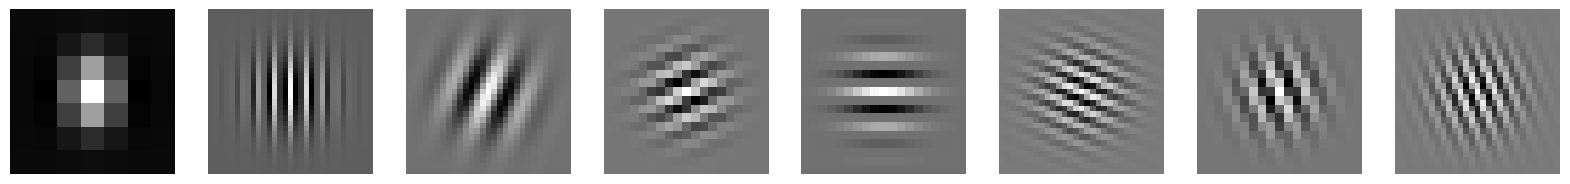

In [85]:
fig = plt.figure(figsize=(20,20))
count = 1
indices = [1,11,21,43, 54, 71, 91, 95]
for i in indices:
    kernel = kernels[i]
    ax = fig.add_subplot(1, 8, count)
    plt.imshow(kernel, cmap='gray')
    plt.axis('off')
    count += 1

In [64]:
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    reshaped_row = row.reshape(shape)

    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(reshaped_row, kernel, mode='wrap')
        feats[k] = stats.describe(filtered.reshape(-1))[2:6]
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

In [66]:
shape = [131,131]
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, data_set, kernels, shape)
print(gabor_stats.shape)

CPU times: user 56min 1s, sys: 1min 11s, total: 57min 12s
Wall time: 57min 43s
(4752, 384)


We built a nearest neighbor classifier to measure the actual classification performance of using Gabor Filters. We also tested how the classifier performs under different train-test splits.

In [72]:
accuracies_gabor = []

# init a classifier for each feature space
for n in range(1,10):
    for seed in range(0,10):
        knn_gabor = KNeighborsClassifier(n_neighbors=n)
        
        # separate the data into train/test
        gabor_train, gabor_test, y_train, y_test = train_test_split(
            gabor_stats, labels, test_size=0.2, train_size=0.8, random_state=seed)
        
        knn_gabor.fit(gabor_train,y_train)
        acc_gabor = accuracy_score(knn_gabor.predict(gabor_test),y_test)
        accuracies_gabor.append(acc_gabor)


,count,mean,std,min,25%,50%,75%,max
0,90.0,0.338836,0.026594,0.281809,0.319926,0.339117,0.355152,0.396425


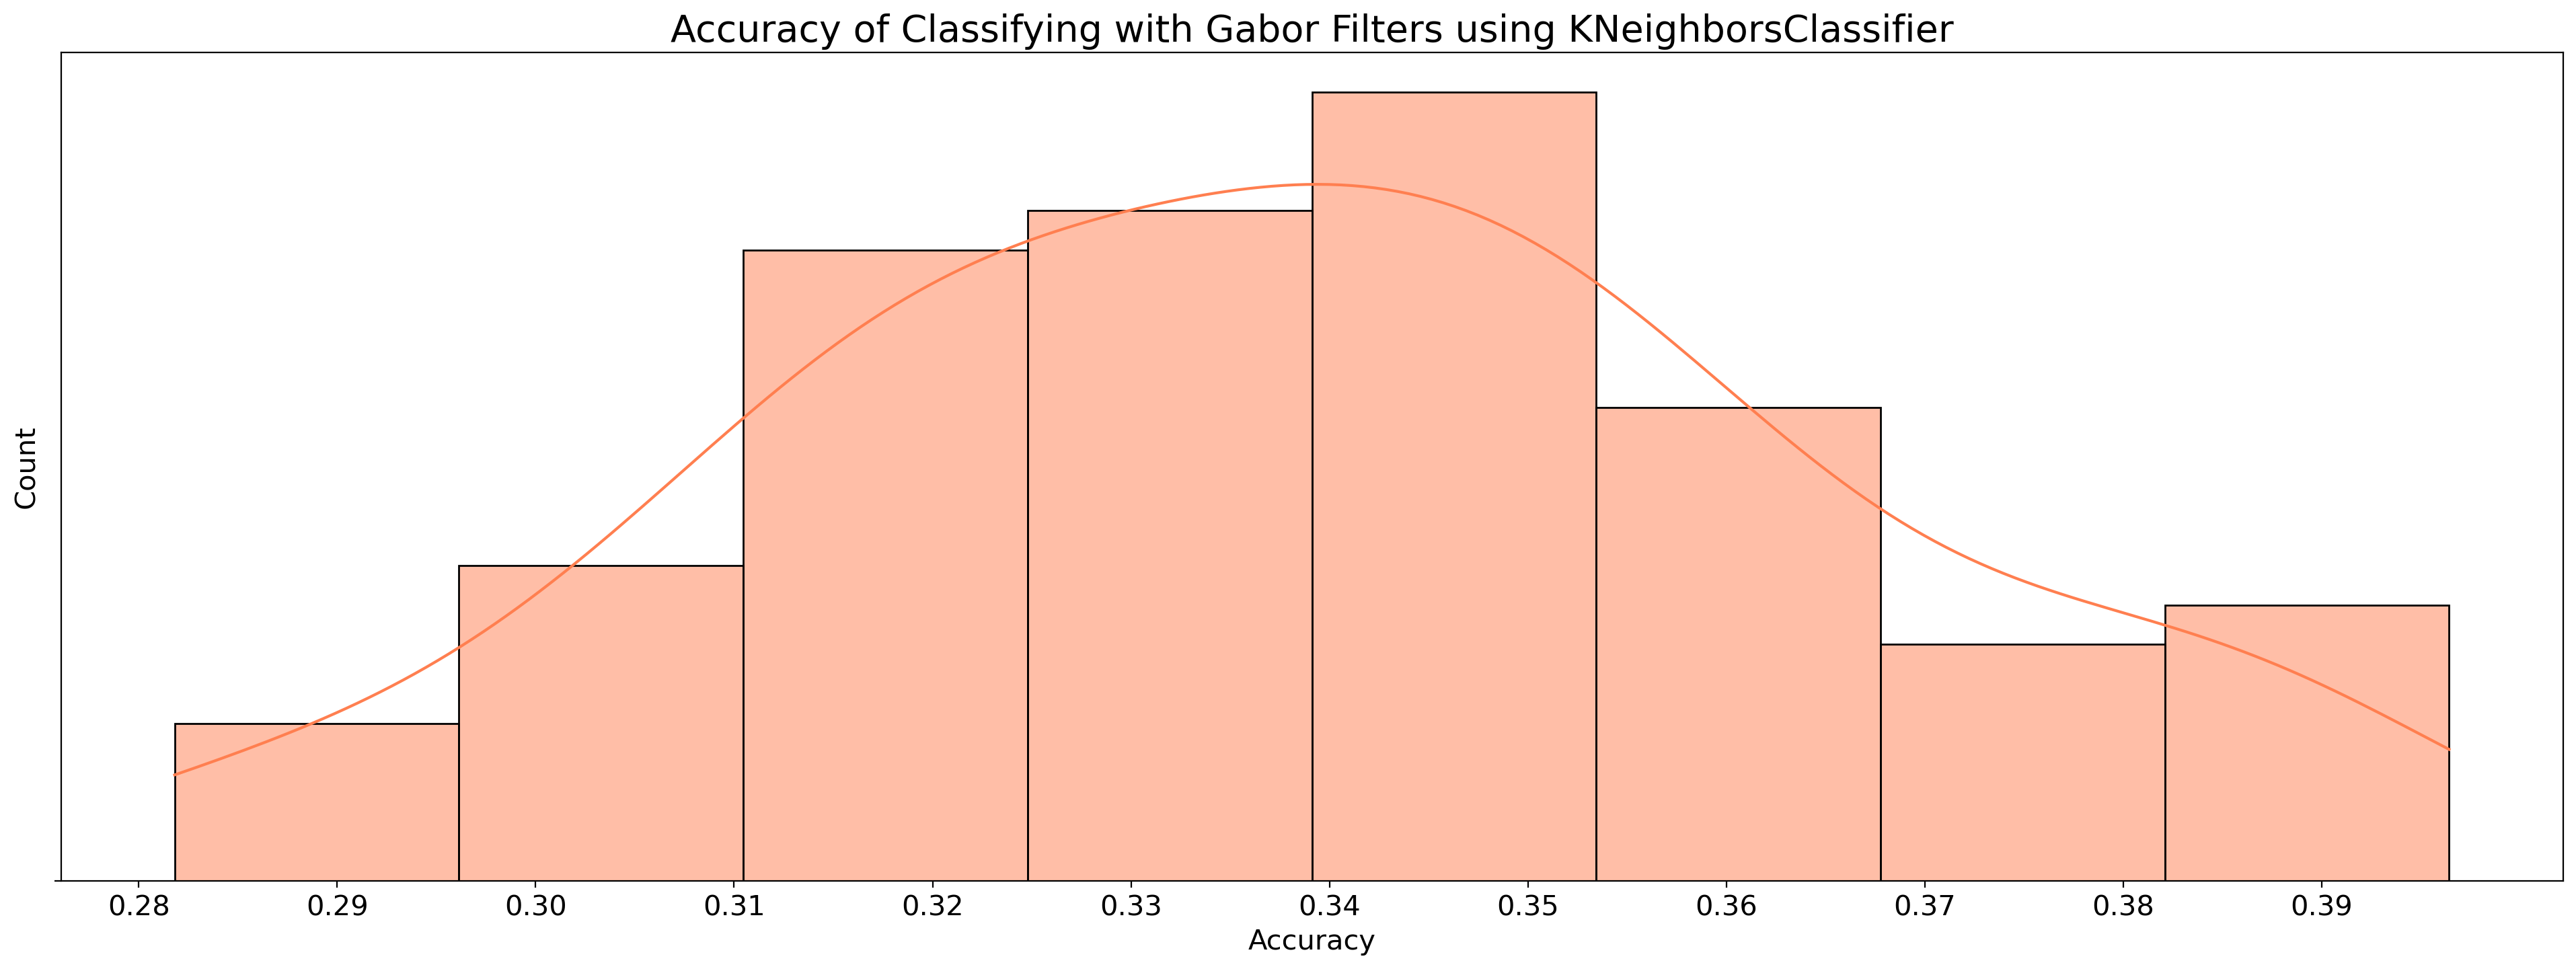

In [75]:
fig, axes = plt.subplots(1,1, figsize=(24,8), dpi=200)
sns.histplot(data=np.array(accuracies_gabor), color='coral', kde=True)
plt.xlabel("Accuracy", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.yticks([0],[''], fontsize=15)
plt.xticks(np.arange(0.28,0.4,0.01),fontsize=15)
plt.margins(x=0.05, y=0.05)
plt.title("Accuracy of Classifying with Gabor Filters using KNeighborsClassifier", fontsize=20);
pd.DataFrame(pd.Series(accuracies_gabor).describe()).transpose()

Our tests showed that the median and mean accuracy of using Gabor Filters was 33.9%. The maximum recorded accuracy was 39.64%, and the minimum recorded accuracy was 33.88%. Compared to the prediction accuracies of normal PCA, randomized PCA, and DAISY, Gabor Filters have too low of an accuracy to show promise for our prediction task. The recorded accuracy for Gabor Filters is also low compared to our target accuracy of 80%. Additionally, using Gabor Filters is infeasible since the algorithm takes 57 minutes to run while other techniques take at most 2 minutes. Given the low prediction accuracy and long execution time, we can conclude that Gabor Filters do not show promise for our prediction task.